# BEiT for AWS Inferentia

This notebook demonstrates how to compile the BEiT model for AWS Inferentia, and then use the compiled model for inference.

**Reference:** https://huggingface.co/docs/transformers/model_doc/beit

## 1) Install dependencies

In [ ]:
#Install Transformers
%pip install -U "transformers==4.21.3"

## 2) Initialize libraries and prepare input samples

In [ ]:
from transformers import BeitFeatureExtractor, BeitForImageClassification
import torch

feature_extractor = BeitFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224")
inputs = torch.randn(3, 224, 224)
x = feature_extractor(inputs, return_tensors="pt")['pixel_values']

## 3) Load a pre-trained model and check if it is .jit traceable

In [ ]:
import types

model = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224")
model.eval()

if not hasattr(model, 'forward_'): model.forward_ = model.forward
# change the forward to make it traceable
model.forward = types.MethodType(lambda self,x: self.forward_(x).logits, model)

labels = model.config.id2label
torch.save(labels, 'labels.pt')

logits = model(x) # warmup
predicted_label = logits.argmax(-1).item()
print(labels[predicted_label])

try:
    traced = torch.jit.trace(model, x)
    print("Cool! Model is jit traceable")
except Exception as e:    
    print("Ops. Something went wrong. Model is not traceable")
## ok the model is .jit traceable. now let's compile it with NeuronSDK

## 4) Analyze & compile the model for Inferentia with NeuronSDK

Neuron Check Model tool provides user with basic information about the compiled and uncompiled model’s operations without the use of TensorBoard-Neuron.  
https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-tools/tutorial-neuron-check-model.html


The PyTorch-Neuron trace Python API provides a method to generate PyTorch models for execution on Inferentia, which can be serialized as TorchScript. It is analogous to torch.jit.trace() function in PyTorch.   
https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-frameworks/pytorch-neuron/api-compilation-python-api.html?highlight=trace

In [ ]:
import torch
import torch.neuron
torch.neuron.analyze_model(model, example_inputs=x)

In [ ]:
import torch
import torch.neuron
model_neuron = torch.neuron.trace(model, example_inputs=x)

## Export to saved model
model_neuron.save("beit_neuron.pt")

### 4.1) Verify the optimized model

In [ ]:
y = model_neuron(x)
%timeit model_neuron(x)

## 5) A simple test to check the predictions

In [ ]:
#Install cv2 and matplotlib
%pip install numpy==1.18.5 matplotlib opencv-python

goldfish, Carassius auratus


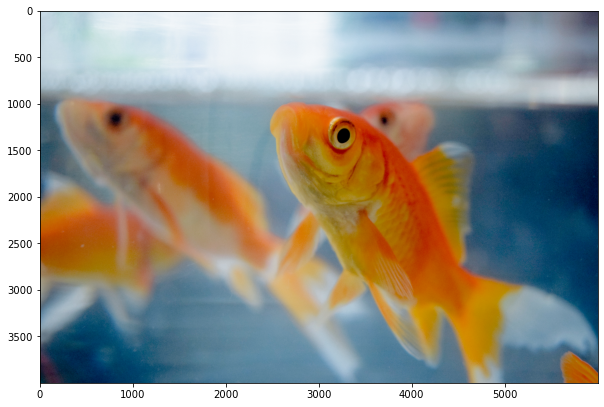

In [6]:
%matplotlib inline
import os
import sys
import cv2
import torch
import torch.neuron
import matplotlib.pyplot as plt
from transformers import BeitFeatureExtractor

if not '..' in sys.path: sys.path.append('..')
from common import processing

feature_extractor = BeitFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224")
labels = torch.load('labels.pt')

model_neuron = torch.load('beit_neuron.pt')
img = processing.load_sample_imgA()

x = feature_extractor(img, return_tensors="pt")['pixel_values']
logits = model_neuron(x)
predicted_label = logits.argmax(-1).item()
print(labels[predicted_label])
plt.figure(figsize=(10,20))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))